# Replicate SJ comparison

In [2]:
!date

Thu Aug 22 12:15:34 PDT 2024


In [3]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/scquint_4


In [4]:
import pandas as pd
import scanpy as sc
import anndata

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats

from scquint.data import load_adata_from_starsolo, add_gene_annotation

import seaborn as sns
from matplotlib_venn import venn2, venn3

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sc.set_figure_params(dpi=160)

In [5]:
input_dir = '/c4/home/derek/data1/derek/data_scSLR/PBMC/'

In [6]:
output_dir = '/c4/home/derek/data1/derek/scSLR/notebooks/fig2/plots/'
os.makedirs(output_dir, exist_ok=True)

# get merged libraries

In [7]:
%%time
adatas_spl = {}
samples = ["sample_1",
           "sample_2"]
library = "shared_merged"
for sample in samples:
    print(sample)
    try:
        adata_spl_sample = load_adata_from_starsolo(input_dir+f"/STAR_outs/{sample}/StarOut_{library}/Solo.out/SJ/raw/", var_filename="SJ.out.tab")
    except:
        adata_spl_sample = load_adata_from_starsolo(input_dir+f"/STAR_outs/{sample}/StarOut_{library}/Solo.out/SJ/raw/", var_filename="features.tsv")
    
    adata_spl_sample = adata_spl_sample[adata_spl_sample.obs_names.isin(pd.read_csv(input_dir+f"/PBMC_{sample}_idents.csv",sep='\t',header=None,index_col=0,names=['celltype']).index)]
    
    sc.pp.calculate_qc_metrics(adata_spl_sample, inplace=True)
        
    adatas_spl[sample] = adata_spl_sample

sample_1
Filtering out undefined strand.


/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


sample_2
Filtering out undefined strand.


/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


CPU times: user 10min 3s, sys: 14.6 s, total: 10min 18s
Wall time: 10min 9s


In [8]:
sc.pp.calculate_qc_metrics(adatas_spl['sample_1'], inplace=True)
sc.pp.calculate_qc_metrics(adatas_spl['sample_2'], inplace=True)

# Plot correlation between biological replicates

In [9]:
adata_SLR_s1 = adatas_spl['sample_1'][:,adatas_spl['sample_1'].var_names.isin(adatas_spl['sample_2'].var_names)]
adata_SLR_s2 = adatas_spl['sample_2'][:,adatas_spl['sample_2'].var_names.isin(adatas_spl['sample_1'].var_names)]

In [19]:
int(np.ceil(len(adata_SLR_s1.var_names)/10))

41292

In [20]:
# subsample var

subsample = np.random.choice(adata_SLR_s1.var_names, int(np.ceil(len(adata_SLR_s1.var_names)/10)), replace = False)

In [21]:
subsample

array(['chr19:17776687-17781230', 'chr10:100256477-100261978',
       'chr16:21385933-21856678', ..., 'chr2:230237261-230241403',
       'chr1:202909125-202918170', 'chr15:77032395-77035507'],
      dtype=object)

In [23]:
adata_SLR_s1_ = adata_SLR_s1[:,subsample]
adata_SLR_s2_ = adata_SLR_s2[:,subsample]

In [24]:
%%time
values = np.vstack([adata_SLR_s1_.var.log1p_total_counts,
                    adata_SLR_s2_.var.log1p_total_counts])

kernel = stats.gaussian_kde(values)(values)

CPU times: user 1min 28s, sys: 4.37 s, total: 1min 32s
Wall time: 1min 27s


In [25]:
%%time
corr = stats.pearsonr(x=adata_SLR_s1_.var.log1p_total_counts,
            y=adata_SLR_s2_.var.log1p_total_counts,)

CPU times: user 3.33 ms, sys: 5.87 ms, total: 9.21 ms
Wall time: 15.9 ms


In [26]:
corr

PearsonRResult(statistic=0.9514571790450701, pvalue=0.0)

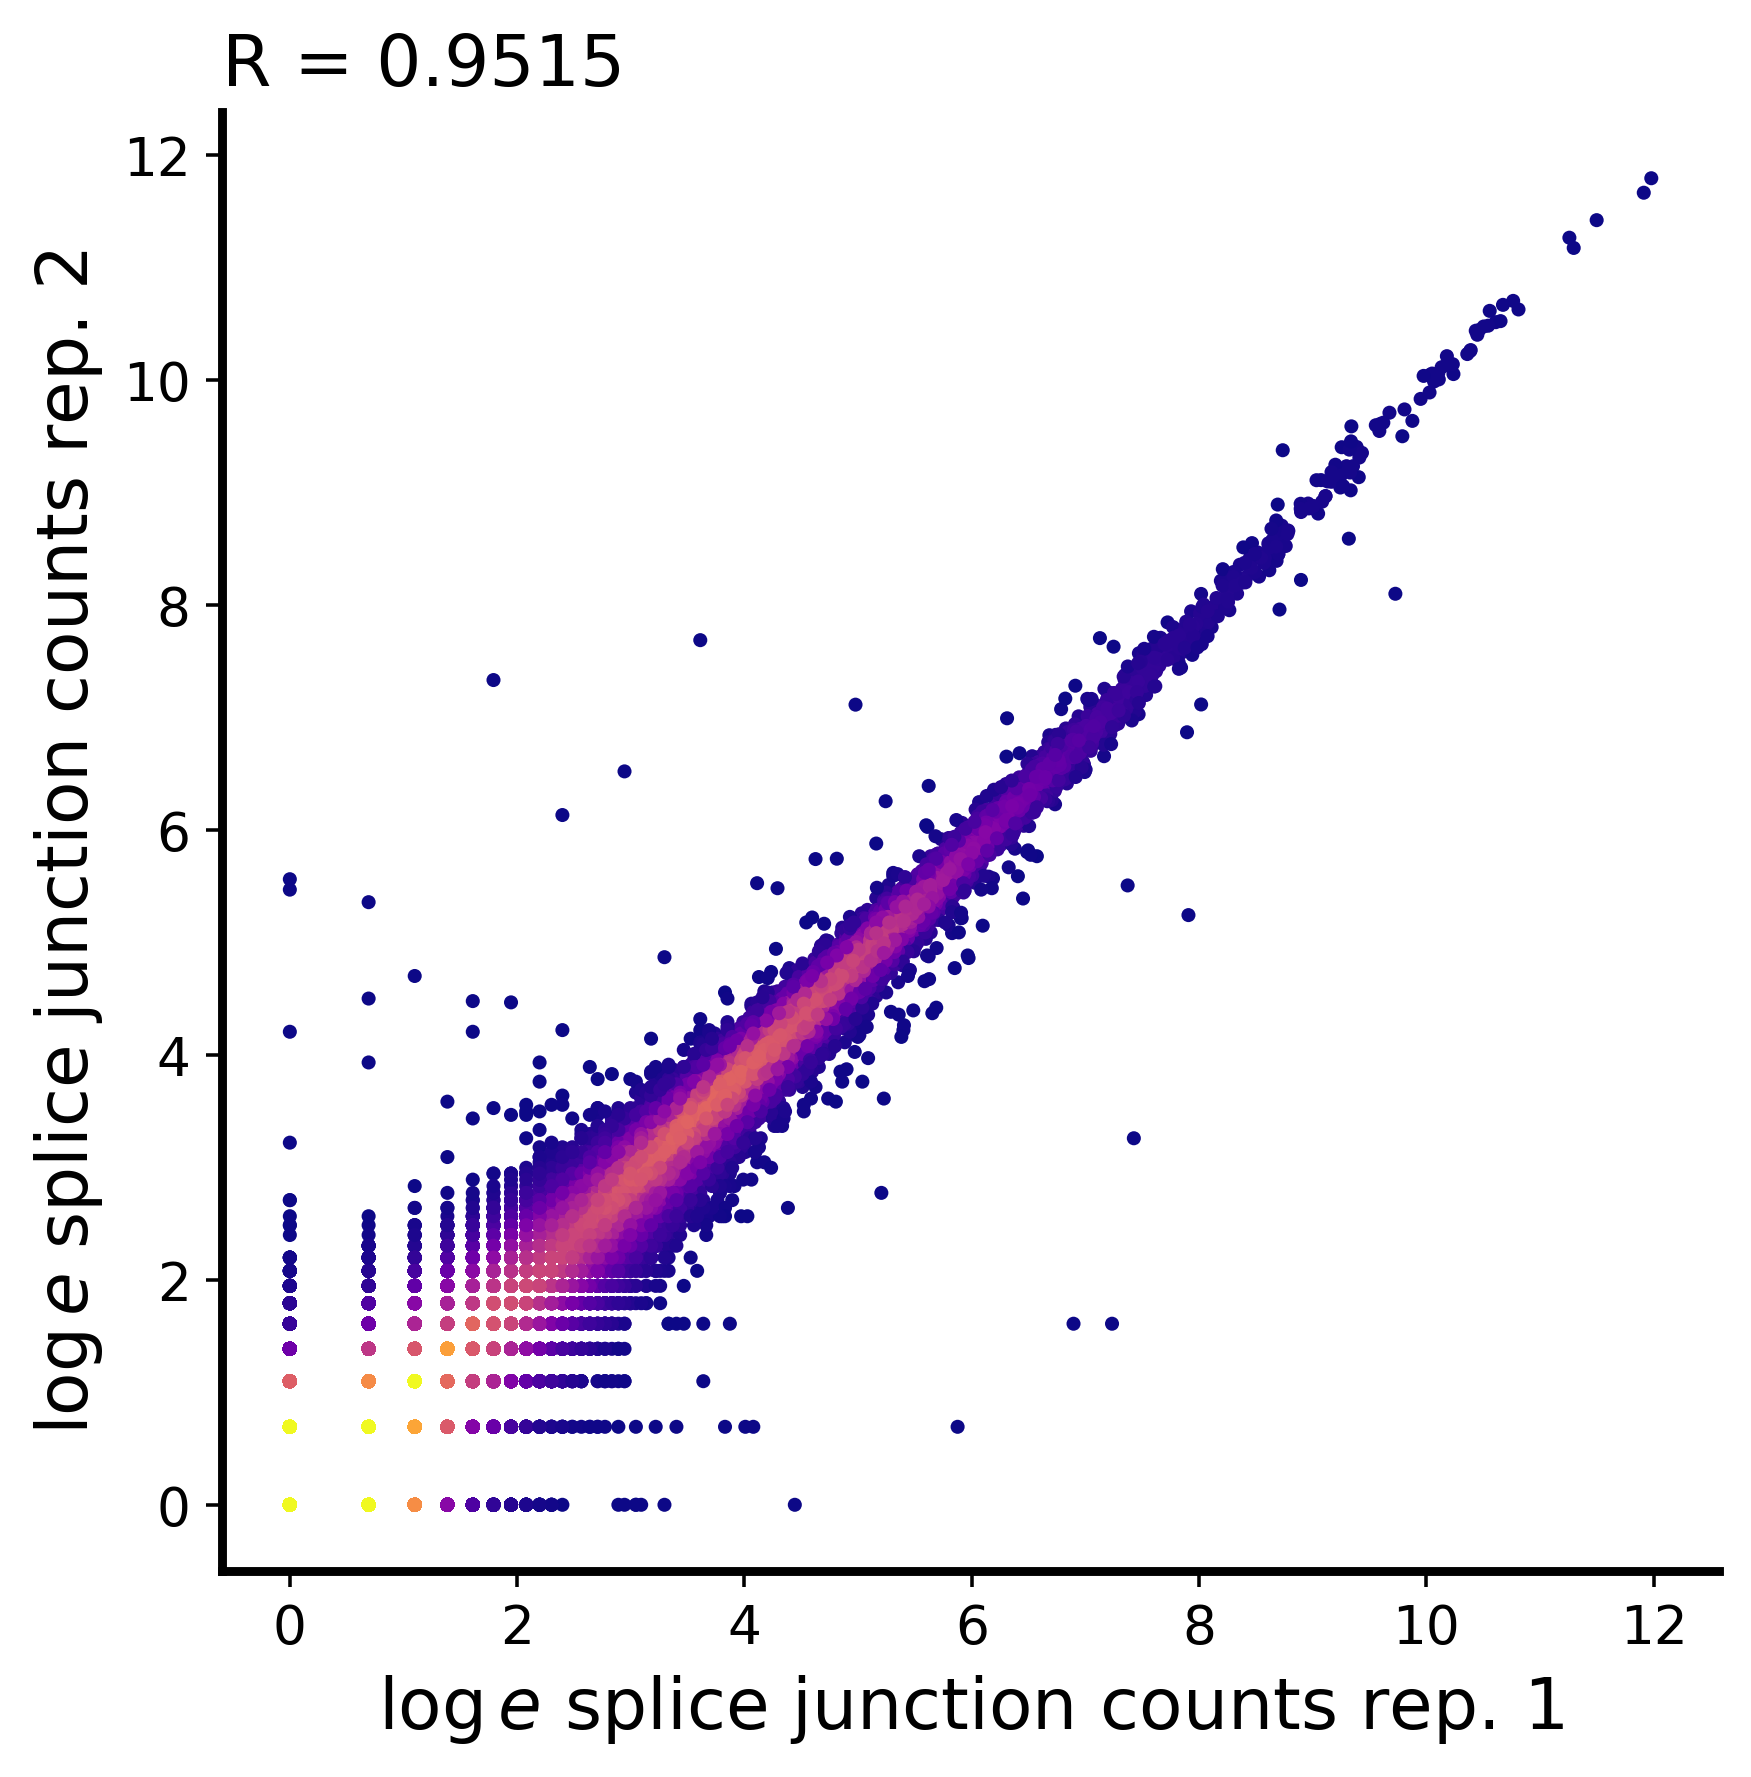

In [33]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))

n = sns.scatterplot(x=values[1],
            y=values[0],
            s=10,
            linewidth=0,
            hue=kernel,
            palette='plasma',
            ax=ax,
            hue_norm = (0,0.2)
           )

ax.get_legend().remove()
# ax.figure.colorbar(n)

ax.grid(False)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.spines.bottom.set_linewidth(2)
ax.spines.left.set_linewidth(2)

ax.set_title(f'R = {round(corr[0],4)}',loc='left',fontsize=16)

ax.set_xlabel(r"$\log{e}$ splice junction counts rep. 1", fontsize=16)
ax.set_ylabel(r"$\log{e}$ splice junction counts rep. 2", fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig('./plots/SLR_lib_replicate_SJ_corr_PBMC.pdf')

In [34]:
!conda list

# packages in environment at /c4/home/derek/miniconda3/envs/scquint_4:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
_r-mutex                  1.0.1               anacondar_1    conda-forge
_sysroot_linux-64_curr_repodata_hack 3                   h69a702a_16    conda-forge
aiofiles                  22.1.0             pyhd8ed1ab_0    conda-forge
aiosqlite                 0.18.0             pyhd8ed1ab_0    conda-forge
anndata                   0.8.0                    pypi_0    pypi
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4                    pypi_0    pypi
archspec                  0.2.3              pyhd8ed1ab_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h5764c6d_3   